In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

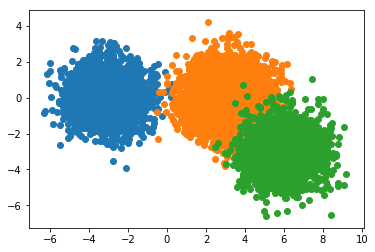

In [4]:
from synthetics_utils import generate_multi_mode_data, generate_label_matrix

# num simulated examples
N = 10000

# mus: [list of d-dim np.arrays] centers of the modes
mus = [
    np.array([-3, 0]), # Mode 1: Y = -1
    np.array([3, 0]), # Mode 2: Y = 1
    np.array([6, -3]) # Mode 3: Y = -1
]
# proportion of data in each mode
props = [0.25, 0.5, 0.25]

# class label of each mode
labels = [-1, 1, -1]

X, Y, C = generate_multi_mode_data(N, mus, props, labels, plot=True)

In [5]:
# "simulated" accuracies and coverage of LFs
accs = np.array([0.75, 0.75, 0.75])
covs = np.array([0.9, 0.9, 0.9])

# overlap between primary "torso" LF and "head" LFs
overlap_portion = 0.05

# labeling function generation
L, overlap_idx = generate_label_matrix(N, accs, covs, Y, C, overlap_portion=overlap_portion)

In [6]:
def eval_model(model,X,L,Y,overlap_idx):
    X_eval = torch.from_numpy(X.astype(np.float32))
#     L_eval = torch.from_numpy(L.astype(np.float32))
    Y_eval = torch.from_numpy(Y.astype(np.float32))
    
    #overall accuracy of the model
    overall_score = model.score((X_eval, Y_eval)) 

    #accuracy of the model on the portion each LF covers
    slice_scores = model.score_on_LF_slices(X, Y, L) 
    try: 
        #accuracy of the model on the overlap between head and torso LF
        overlap_scores = model.score_on_LF_slices(X[overlap_idx,:], Y[overlap_idx], L[overlap_idx,:]) 
    except: 
        overlap_scores = [0,0,0] 
    return  [list(slice_scores)+list(overlap_scores)+list([overall_score])][0]

In [7]:
def train_models(X,L, accs):
    """
    Trains baseline, oracle, and attention model
    Args:
        - X: features
        - L: LF matrix
        - accs: [list of floats] accuracies for LFs
    Returns:
        - model_[0,1,2]: trained baseline, oracle, and attention model
    """

    m = np.shape(L)[1] #num LFs
    d = X.shape[1] #num features
    X_train = torch.from_numpy(X.astype(np.float32))
    L_train = torch.from_numpy(L.astype(np.float32))

    #baseline model, no attention
    r = 4
    model_0 = SliceDPModel(LinearModule(d, r), accs, r=r, rw=False)
    model_0.train_model((X_train, L_train), batch_size=1000, n_epochs=250, lr=0.1, print_every=50, validation_metric='f1', disable_prog_bar=True)

    #oracle, manual reweighting
    #TODO: currently hardcode weights so LF[-1] has double the weight
    weights = np.ones(m, dtype=np.float32)
    weights[-1] = 2.0
    r = 4
    model_1 = SliceDPModel(LinearModule(d, r), accs, r=r, rw=False, L_weights=weights)
    model_1.train_model((X_train, L_train), batch_size=1000, n_epochs=250, lr=0.1, print_every=50, validation_metric='f1', disable_prog_bar=True)

    #our model, with attention
    r = 2
    model_2 = SliceDPModel(LinearModule(d, r), accs, r=r, rw=True)
    model_2.train_model((X_train, L_train), batch_size=1000, n_epochs=250, lr=0.1, print_every=50, validation_metric='f1', disable_prog_bar=True)
    
    return model_0, model_1, model_2

In [8]:
from metal.contrib.slicing.online_dp import LinearModule, SliceDPModel

#train the models and score the models (I KNOW ITS UGLY)
model_0, model_1, model_2 = train_models(X,L,accs)

Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (0): LinearModule(
      (input_layer): Linear(in_features=2, out_features=4, bias=False)
    )
    (1): ReLU()
  )
)
L_head: Linear(in_features=4, out_features=3, bias=False)
Y_head: Linear(in_features=4, out_features=2, bias=False)
[E:0]	Train Loss: 0.004
[E:50]	Train Loss: 0.004
[E:100]	Train Loss: 0.004
[E:150]	Train Loss: 0.004
[E:200]	Train Loss: 0.004
[E:249]	Train Loss: 0.004
Finished Training
Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (0): LinearModule(
      (input_layer): Linear(in_features=2, out_features=4, bias=False)
    )
    (1): ReLU()
  )
)
L_head: Linear(in_features=4, out_features=3, bias=False)
Y_head: Linear(in_features=4, out_features=2, bias=False)
[E:0]	Train Loss: 0.005
[E:50]	Train Loss: 0.005
[E:100]	Train Loss: 0.005
[E:150]	Train Loss: 0.005
[E:200]	Train Loss: 0.005
[E:249]	Train Loss: 0.005
Finished Training
Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (

In [9]:
model_0_scores = []
model_1_scores = []
model_2_scores = []

for model, m_scores in zip([model_0, model_1, model_2],[model_0_scores, model_1_scores, model_2_scores]):
    a,b,c,d,e,f,g = eval_model(model,X,L,Y,overlap_idx)
    m_scores.append([a,b,c,d,e,f,g])

Accuracy: 0.387
        y=1    y=2   
 l=1   3873    227   
 l=2   1127   4773   
Accuracy: 0.398
        y=1    y=2   
 l=1   3979    241   
 l=2   1021   4759   
Accuracy: 0.488
        y=1    y=2   
 l=1   4885    281   
 l=2    115   4719   


In [10]:
scores = pd.DataFrame([[model_0_scores[0][i] for i in [0,1,2,5,6]], [model_1_scores[0][i] for i in [0,1,2,5,6]], [model_2_scores[0][i] for i in [0,1,2,5,6]]])
scores.columns = (['LF0_slice', 'LF1_slice', 'LF2_slice', 'LF1+2_overlap', 'Overall'])
scores.index = (['Baseline', 'Manual', 'Ours'])
scores

,LF0_slice,LF1_slice,LF2_slice,LF1+2_overlap,Overall
Baseline,0.980863,0.777512,0.929947,0.915385,0.3873
Manual,0.995995,0.798826,0.910245,0.907692,0.3979
Ours,0.999110,0.974337,0.890981,0.907692,0.4885
